# Classification. Linear models and KNN

In [2]:
# Basic 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

# EDA
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report

# Modeling
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier


In [2]:
#from google.colab import files
#uploaded = files.upload()
#uploaded

In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive/')

#!unzip -q /content/gdrive/MyDrive/Colab_data/porto.zip -d porto

Mounted at /content/gdrive/


## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [54]:
insurance_data = pd.read_csv(os.path.join('train.csv')).set_index('id')
#insurance_data = pd.read_csv(os.path.join('porto','train.csv')).set_index('id')
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [55]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [56]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [57]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [58]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [59]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

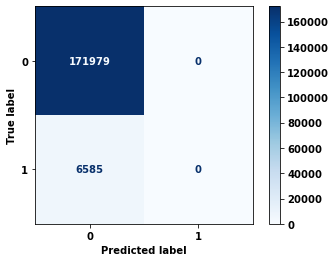

In [10]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [11]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

In [60]:
y_pred = clf.predict_proba(X_valid)[:, 1]
gini_normalized(y_valid, y_pred)

0.2558723581569817

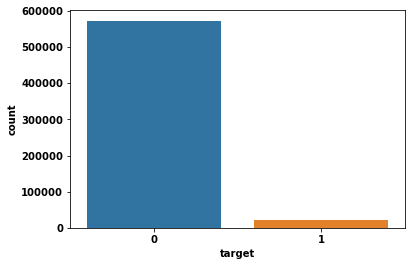

In [12]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

Построить графики ROC и NGini

In [13]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''

    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

Обычно в статьях дается простое объяснение c картинкой вроде такой:

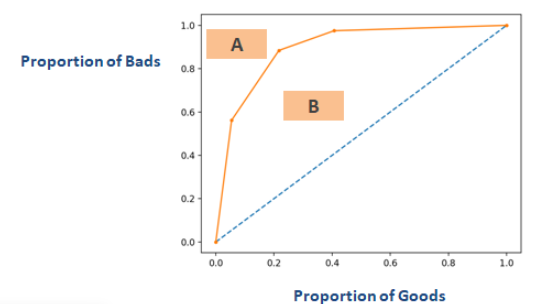

Gini = B / (A + B)

A + B = 0.5

Из чего следует Gini = B / 0.5 = 2 * B

AUC = B + 0.5

Тогда можно подставить Gini = 2*(AUC - 0.5) = 2*AUC - 1

Но, иногда утверждается, что это не корректно т.к. для Gini Coefficient строится Lift сurve (или Gain сurve в других источниках) и выглядит она иначе.

ROC curve строится в координатах False Positive Rate / True Positive Rate. А Gain сurve в координатах Positive Rate / True Positive Rate и никогда не попадает в точку (0, 1) даже для идеальной модели. А Gini Coefficient будет соотношением площадей под model gain сurve - 0.5 и ideal model gain сurve - 0.5

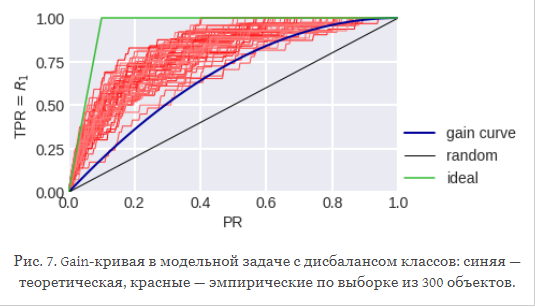

По выводу равенства подробно описано здесь: [https://habr.com/ru/company/ods/blog/350440/](https://habr.com/ru/company/ods/blog/350440/)

Там же есть доказательство:

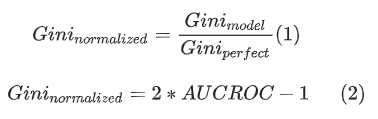

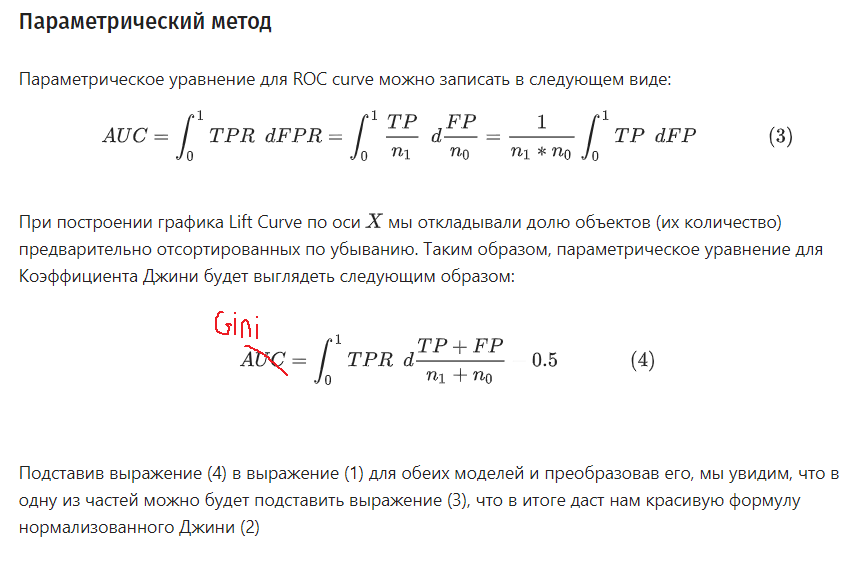

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

Можно посмотреть "macro-усредненные" по классам метрики:

In [15]:
from sklearn.metrics import classification_report
report_dict = classification_report(y_valid, clf.predict(X_valid), output_dict=True,zero_division=0)
pd.DataFrame(report_dict)

,0,1,accuracy,macro avg,weighted avg
precision,0.963122,0.0,0.963122,0.481561,0.927605
recall,1.000000,0.0,0.963122,0.500000,0.963122
f1-score,0.981215,0.0,0.963122,0.490607,0.945030
support,171979.000000,6585.0,0.963122,178564.000000,178564.000000


Можно смотреть AUC-ROC, для сравнения алгоритмов. Хотя, для обучения это не всегда лучший выбор. ROC ведь еще зависит от выбора конкретной вероятности.

Для несбалансированных выборок хорошо подходят F1-score и [Matthews correlation coefficient](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient)

In [16]:
from sklearn.metrics import roc_auc_score, f1_score, matthews_corrcoef

print(roc_auc_score(y_valid, clf.predict(X_valid)))
print(f1_score(y_valid, clf.predict(X_valid)))
print(matthews_corrcoef(y_valid, clf.predict(X_valid)))

0.5
0.0
0.0


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:846: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Let's calculate the Normalized Gini Coefficient:

In [17]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [18]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

# EDA

In [ ]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [9]:
positive_data = insurance_data[insurance_data.target == 1]
negative_data = insurance_data[insurance_data.target == 0]

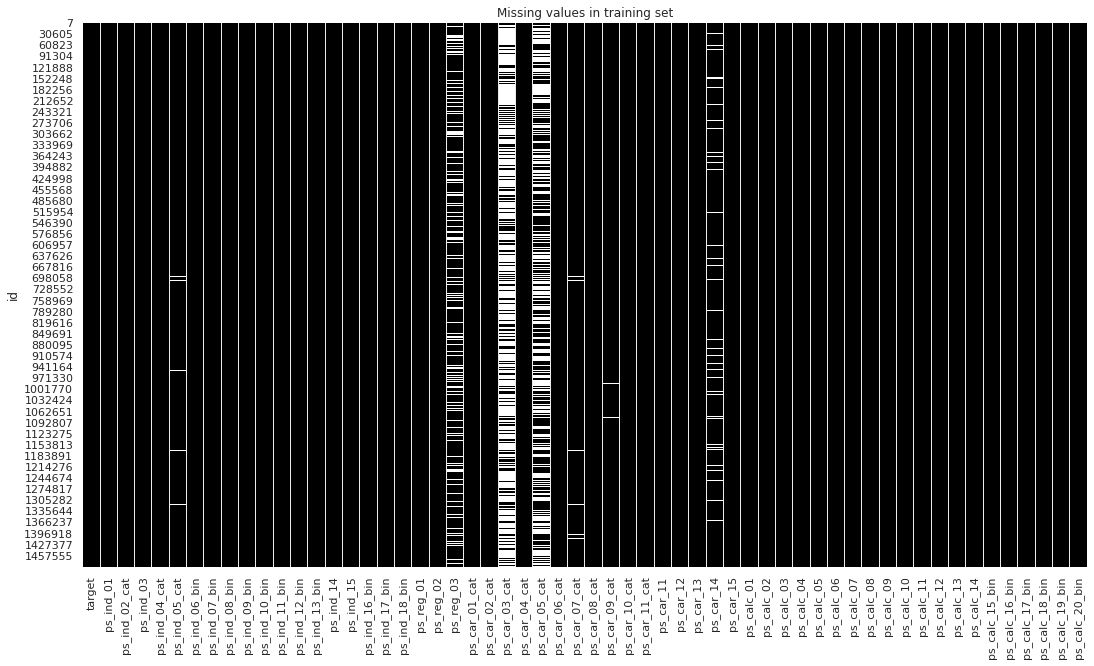

In [ ]:
plt.figure(figsize=(18,10))
sns.heatmap(insurance_data==-1, cmap='gray', cbar=False)
plt.title('Missing values in training set')
plt.show()

In [ ]:
summary = pd.DataFrame(insurance_data.dtypes, columns=['dtype'])
# Number of Missing values (-1 count)
summary['num_missing'] = (insurance_data == -1).sum().values    
# Number of unique values by features
summary['num_uniques'] = insurance_data.nunique().values

data_forms = []
for col in insurance_data.columns:
    if 'bin' in col or col == 'target':
        data_forms.append('binary')
    elif 'cat' in col:
        data_forms.append('nominal')
    elif insurance_data[col].dtype == float:
        data_forms.append('continuous')
    elif insurance_data[col].dtype == int:
        data_forms.append('ordinal')

summary['role'] = data_forms
summary[summary['num_missing']>0]

,dtype,num_missing,num_uniques,role
ps_ind_02_cat,int64,216,5,nominal
ps_ind_04_cat,int64,83,3,nominal
ps_ind_05_cat,int64,5809,8,nominal
ps_reg_03,float64,107772,5013,continuous
ps_car_01_cat,int64,107,13,nominal
ps_car_02_cat,int64,5,3,nominal
ps_car_03_cat,int64,411231,3,nominal
ps_car_05_cat,int64,266551,3,nominal
ps_car_07_cat,int64,11489,3,nominal
ps_car_09_cat,int64,569,6,nominal


In [ ]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]

# Sampling

Данных у нас много. Попробуем начать с UnderSampling

In [ ]:
from imblearn.under_sampling import NearMiss
nm = NearMiss(return_indices=True)
nm

NearMiss(n_jobs=1, n_neighbors=3, n_neighbors_ver3=3, random_state=None,
         ratio=None, return_indices=True, sampling_strategy='auto', version=1)

In [ ]:
sns.countplot(x=y_us)
plt.show()

In [ ]:
## your code

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

print(X_train.shape, X_valid.shape)
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.fit_transform(X_valid)
print(X_train.shape, X_valid.shape)

(416648, 57) (178564, 57)
(416648, 244) (178564, 244)


In [21]:
from imblearn.under_sampling import NearMiss 

print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
# apply near miss 

nr = NearMiss() 
  
X_train_us, y_train_us = nr.fit_sample(X_train, y_train) 
  
print('After Undersampling, the shape of train_X: {}'.format(X_train_us.shape)) 
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_us.shape)) 
  
print("After Undersampling, counts of label '1': {}".format(sum(y_train_us == 1))) 
print("After Undersampling, counts of label '0': {}".format(sum(y_train_us == 0))) 

Before Undersampling, counts of label '1': 15186
Before Undersampling, counts of label '0': 401462 

After Undersampling, the shape of train_X: (30372, 244)
After Undersampling, the shape of train_y: (30372,) 

After Undersampling, counts of label '1': 15186
After Undersampling, counts of label '0': 15186


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.pipeline import Pipeline as imb_pipeline

#roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True) #, needs_threshold=True # используем predict 
#roc_auc_scorer = make_scorer(roc_auc_score, needs_threshold=True) # используем predict_proba  needs_proba=True,  needs_threshold

gini_scorer = make_scorer(gini_normalized, greater_is_better=True,needs_threshold=True)


In [49]:
classifier = SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14)
classifier.fit(X_train_us, y_train_us)

SGDClassifier(alpha=0.001, loss='log', n_jobs=-1, random_state=14)

In [52]:
# LogLoss
classifier = SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14)
params =  {'alpha': np.arange(0.00001,0.001,0.0005)}
GS = GridSearchCV(classifier, param_grid=params, scoring=gini_scorer,n_jobs=-1)

GS.fit(X_train_us, y_train_us)
print(GS.best_score_)
print(GS.best_params_)

y_pred = GS.predict(X_valid) 
y_proba = GS.predict_proba(X_valid)[:, 1]
print(gini_normalized(y_valid, y_proba))
report_dict = classification_report(y_valid, y_pred, output_dict=True)
pd.DataFrame(report_dict)

0.8622588978847945
{'alpha': 0.00051}
0.16993906250779484


,0,1,accuracy,macro avg,weighted avg
precision,0.973941,0.039545,0.254211,0.506743,0.939886
recall,0.232215,0.835741,0.254211,0.533978,0.254211
f1-score,0.375016,0.075516,0.254211,0.225266,0.364100
support,172056.000000,6508.000000,0.254211,178564.000000,178564.000000


In [29]:
# KNN
classifier = KNeighborsClassifier(metric='manhattan') # n_neighbors=5 metric= 
params = {'n_neighbors': np.arange(28,61)} #np.arange(2,11)  'n_neighbors': np.arange(2,11), 
GS = GridSearchCV(classifier, param_grid=params, scoring=roc_auc_scorer,n_jobs=-1)

GS.fit(X_train_us, y_train_us)
print(GS.best_score_)
print(GS.best_params_)

y_pred = GS.predict(X_valid) 
y_proba = GS.predict_proba(X_valid)[:, 1]
print(gini_normalized(y_valid, y_proba))
report_dict = classification_report(y_valid, y_pred, output_dict=True)
pd.DataFrame(report_dict)

0.8650578333211243
{'n_neighbors': 30}


,0,1,accuracy,macro avg,weighted avg
precision,0.969246,0.053780,0.742933,0.511513,0.935881
recall,0.757236,0.364782,0.742933,0.561009,0.742933
f1-score,0.850224,0.093740,0.742933,0.471982,0.822653
support,172056.000000,6508.000000,0.742933,178564.000000,178564.000000


In [30]:
y_proba = GS.predict_proba(X_valid)[:, 1]
print(gini_normalized(y_valid, y_proba))

0.18174203347648385


In [31]:
# DecisionTree
# В лекции разрешили использовать деревья
from sklearn.tree import DecisionTreeClassifier 

classifier = DecisionTreeClassifier(random_state=0)
params =  {'criterion': ('gini', 'entropy'), 'max_depth': np.arange(2,24,2)}
GS = GridSearchCV(classifier, param_grid=params, scoring=roc_auc_scorer,n_jobs=-1)

GS.fit(X_train_us, y_train_us)
print(GS.best_score_)
print(GS.best_params_)

y_pred = GS.predict(X_valid) 
y_proba = GS.predict_proba(X_valid)[:, 1]
print(gini_normalized(y_valid, y_proba))
report_dict = classification_report(y_valid, y_pred, output_dict=True)
pd.DataFrame(report_dict)

0.8821698112938808
{'criterion': 'entropy', 'max_depth': 8}
0.16095127965317352


,0,1,accuracy,macro avg,weighted avg
precision,0.975239,0.041276,0.314408,0.508258,0.941200
recall,0.295991,0.801321,0.314408,0.548656,0.314408
f1-score,0.454146,0.078508,0.314408,0.266327,0.440455
support,172056.000000,6508.000000,0.314408,178564.000000,178564.000000


In [53]:
# RandomForest
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=0, criterion='entropy')
params =  {'max_depth': np.arange(2,24,2)} #'max_depth': np.arange(2,24,2), 'n_estimators': np.arange(100,1000,500) 'criterion': ('gini', 'entropy')
GS = GridSearchCV(classifier, param_grid=params, scoring=gini_scorer,n_jobs=-1)

GS.fit(X_train_us, y_train_us)
print(GS.best_score_)
print(GS.best_params_)

y_pred = GS.predict(X_valid) 
y_proba = GS.predict_proba(X_valid)[:, 1]
print(gini_normalized(y_valid, y_proba))
report_dict = classification_report(y_valid, y_pred, output_dict=True)
pd.DataFrame(report_dict)

0.8650821760180065
{'max_depth': 22}
0.1867572492884339


,0,1,accuracy,macro avg,weighted avg
precision,0.975521,0.040461,0.275347,0.507991,0.941442
recall,0.254318,0.831285,0.275347,0.542801,0.275347
f1-score,0.403456,0.077166,0.275347,0.240311,0.391564
support,172056.000000,6508.000000,0.275347,178564.000000,178564.000000


In [42]:
test_data = pd.read_csv(os.path.join('test.csv')).set_index('id')
#insurance_data = pd.read_csv(os.path.join('porto','train.csv')).set_index('id')
test_data.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,8,1,0,0,1,0,0,0,...,1,1,1,12,0,1,1,0,0,1
1,4,2,5,1,0,0,0,0,1,0,...,2,0,3,10,0,0,1,1,0,1
2,5,1,3,0,0,0,0,0,1,0,...,4,0,2,4,0,0,0,0,0,0
3,0,1,6,0,0,1,0,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,5,1,7,0,0,0,0,0,1,0,...,4,0,0,4,0,1,1,0,0,1


In [45]:
X_test = preprocessor.fit_transform(test_data)
print(test_data.shape, X_test.shape)

(892816, 57) (892816, 244)


In [47]:
submission = pd.read_csv(os.path.join('./', 'sample_submission.csv')).set_index('id')
submission['target'] = GS.predict_proba(X_test)[:, 1]
submission

,target
id,
0,0.607529
1,0.716000
2,0.559679
3,0.147453
4,0.463599
...,...
1488022,0.940000
1488023,0.940000
1488024,0.651733


In [4]:
submission.to_csv('./my_submission_1_rfc.csv')

NameError: name 'submission' is not defined

**Скорр на тесте 0.18. Я может еще поковыряюсь в чем дело и выложу отдельным ноутбуком, без оценки.**

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.